In [4]:
%load_ext autoreload
%autoreload 2

from src.models.beacon_model import BeaconModel
from src.models.wifi_model import WifiModel
from src.data.datasets import FloorDataset
from src.utils import object_to_markdown, get_study
from src.plotting import plot_traces, plot_wifi, plot_beacons

from IPython.display import display

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch

site_id = "5a0546857ecc773753327266"
floor_id = "B1"

floor_data_beacon = FloorDataset(
        site_id, 
        floor_id, 
        wifi_threshold=200, 
        sampling_interval=100, 
        include_wifi=True, 
        include_beacon=True,        
        validation_percent=None,
        test_percent=0.15
        )

floor_data_full_beacon = FloorDataset(
        site_id, 
        floor_id, 
        wifi_threshold=200, 
        sampling_interval=100, 
        include_wifi=True, 
        include_beacon=True,        
        )

floor_data_wifi = FloorDataset(
        site_id, 
        floor_id, 
        wifi_threshold=200, 
        sampling_interval=100, 
        include_wifi=True, 
        include_beacon=False,        
        validation_percent=None,
        test_percent=0.15
        )

floor_data_full_wifi = FloorDataset(
        site_id, 
        floor_id, 
        wifi_threshold=200, 
        sampling_interval=100, 
        include_wifi=True, 
        include_beacon=False,        
        )


floor_image = floor_data_beacon.image
floor_height = floor_data_beacon.info["map_info"]["height"]
floor_width = floor_data_beacon.info["map_info"]["width"]
sns.set(style="whitegrid")

train_indices = (~floor_data_beacon.test_mask & ~floor_data_beacon.validation_mask).nonzero().flatten()
test_indices = floor_data_beacon.test_mask.nonzero().flatten()

mini_batch_train_beacon = floor_data_full_beacon[train_indices[[2, 6, 9, 16, 23, 40, 67]]]
mini_batch_test_beacon = floor_data_full_beacon[test_indices[[3,6,9,10]]]

mini_batch_train_wifi = floor_data_full_wifi[train_indices[[2, 6, 9, 16, 23, 40, 67]]]
mini_batch_test_wifi = floor_data_full_wifi[test_indices[[3,6,9,10]]]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Hyperparameter search

As mentioned in the previous notebooks, the predictive performance of our models were quite poor, and the models prediction of the positions of the wifi and beacons were not that impressive. 

Trying to improve this, we opted for a structured approach to try and improve the fit of our models. More specifically we used hyperparameter search through [optuna](https://optuna.org). Our search space consisted of the following parameters:

 - Learning rate
 - Whether to use ClippedAdam or Adam
 - If using ClippedAdam, what should the learning rate decay be at?
 - Initial KL-term scaling, $\beta_0$. We hoped that scaling the KL-term down initially, such that the model fit focused on the reconstruction loss would help the model fit.
 - The $\sigma$ parameter in $x_t \sim \mathcal{N}(x_t | x_{t-1}, \sigma)$. We were unsure of what a reasonable value of this parameter could be. In hindsight, it would probably have been more simple/correct to simply model this parameter as a latent variable and then model this uncertainty explicitly.
 
Below, we extract the result of the hyperparameter search for each of the models, and plot the corresponding loss curves.

In [5]:
from src.utils import get_study

In [6]:
initial_study = get_study("initial", "optuna-storage-initial.db")
initial_df = pd.DataFrame.from_records(x.intermediate_values for x in initial_study.trials).T.melt()
wifi_study = get_study("wifi", "optuna-storage.db")
beacon_study = get_study("beacon", "optuna-storage.db")

KeyError: 'Record does not exist.'

In [ ]:
initial_df = pd.DataFrame.from_records(x.intermediate_values for x in initial_study.trials).T.reset_index().melt("index")
wifi_df = pd.DataFrame.from_records(x.intermediate_values for x in wifi_study.trials).T.reset_index().melt("index")
beacon_df = pd.DataFrame.from_records(x.intermediate_values for x in beacon_study.trials).T.reset_index().melt("index")

In [5]:
initial_df["Model"] = "Initial Model"
wifi_df["Model"] = "Wifi Model"
beacon_df["Model"] = "Beacon Model"

In [6]:
loss_curves = initial_df.append(wifi_df).append(beacon_df).rename(columns = {"index" : "Epoch", "variable" : "trial", "value" : "Negative ELBO"})

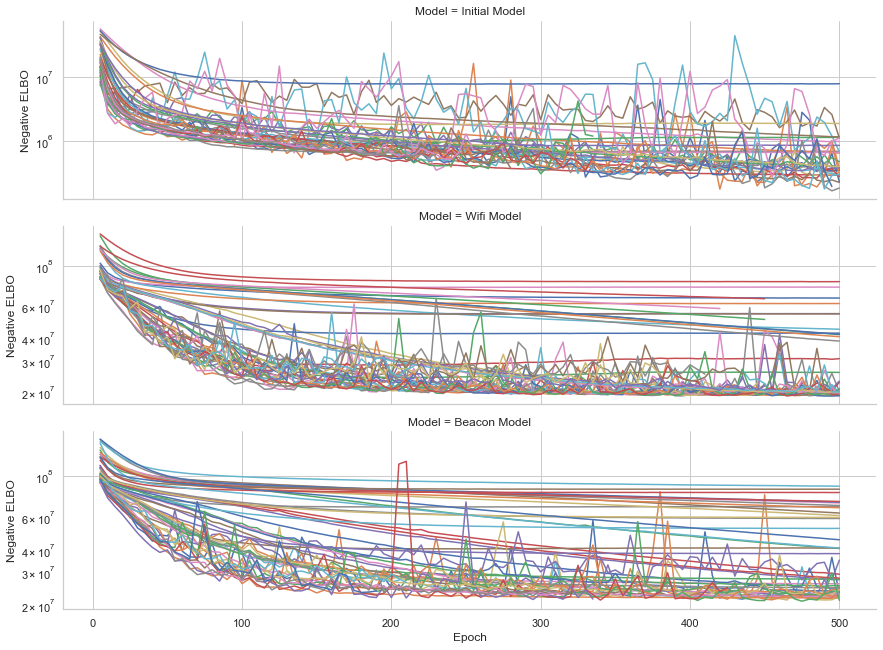

In [7]:
sns.relplot(
    data=loss_curves,
    x="Epoch", 
    y="Negative ELBO", 
    hue="trial", 
    kind="line", 
    row="Model",
    palette="deep", 
    legend=None,
    aspect=4,
    estimator=None,
    height=3,
    facet_kws={"sharey": False}
).set(yscale="log")
plt.show()

We may also extract the best parameters found be the hyperparameters search:

In [8]:
pd.DataFrame({
    "Initial Model" : initial_study.best_params,
    "Wifi Model" : wifi_study.best_params,
    "Beacon Model" : beacon_study.best_params,
}).T.rename(columns = {"beta_0" : "$\\beta_0$", "sigma_eps" : "$\\sigma$" })

,$\beta_0$,clip,lr,$\sigma$
Initial Model,0.039712,False,0.008357,0.265022
Wifi Model,0.62112,False,0.030086,0.441073
Beacon Model,0.003972,False,0.040198,0.429007


These are the hyperparameters used for training the models throughout the project. 

## Optimized for predictive power
Due to bad performance on infering the location in the predictive models (wifi and beacon), we also tried to choose the models hyperparameters using a measure on the location predictive performance, 
$$MSE = \frac{1}{|I|}\sum_{i \in I} ||\boldsymbol x_i - \boldsymbol{\hat x_i}||$$ 
where the index set $I$ contains the times (and trace id) when $\boldsymbol{\hat x_i}$ in a trace in the test set is observed. 

Optimizing using this MSE measure yields the following results on the wifi model and beacon model

In [9]:
wifi_study_mse = get_study("mse_wifi", "optuna-storage-mse.db")
beacon_study_mse = get_study("mse_beacon", "optuna-storage-mse.db")

In [10]:
wifi_df_mse = pd.DataFrame.from_records(x.intermediate_values for x in wifi_study_mse.trials).T.reset_index().melt("index")
beacon_df_mse = pd.DataFrame.from_records(x.intermediate_values for x in beacon_study_mse.trials).T.reset_index().melt("index")

wifi_df_mse["Model"] = "Wifi Model"
beacon_df_mse["Model"] = "Beacon Model"

In [20]:
loss_curves_mse = wifi_df_mse.append(beacon_df_mse).rename(columns = {"index" : "Epoch", "variable" : "trial", "value" : "Test MSE"})

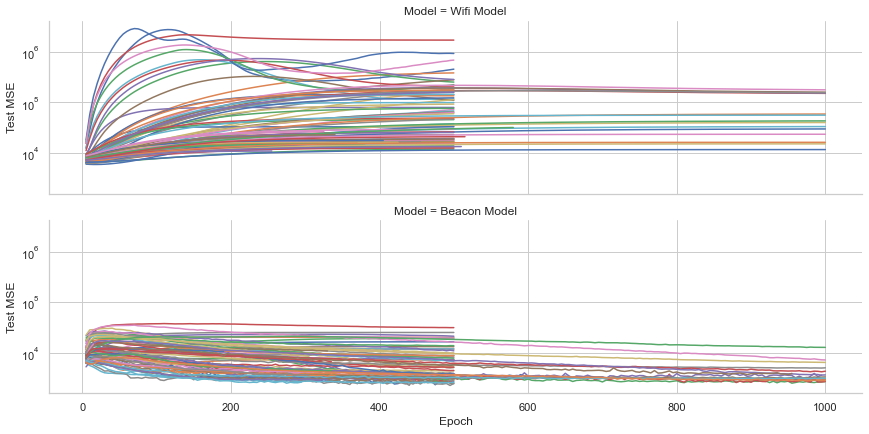

In [22]:
sns.relplot(
    data=loss_curves_mse,
    x="Epoch", 
    y="Test MSE", 
    hue="trial", 
    kind="line", 
    row="Model",
    palette="deep", 
    legend=None,
    aspect=4,
    estimator=None,
    height=3
).set(yscale="log")
plt.show()

We see that the MSE doesn't neccesarily go down as the models are training. We also tried doing some trials with more epochs, however this doesn't really seem to have made a difference. Generally the beacon model seems to perform better with respect to MSE, which was also what we saw with the beacon model earlier; that it seems to help reign the trace guides in a bit.

Below we investigate the behavior of the best models found during these runs

In [23]:
wifi_model_mse = WifiModel(floor_data_wifi)
beacon_model_mse = BeaconModel(floor_data_beacon)

checkpoint_wifi = torch.load(f"../checkpoints/mse_wifi_hparam_0{wifi_study_mse.best_trial.number}.pt", map_location="cpu")
wifi_model_mse.load_state_dict(checkpoint_wifi["model_state_dict"])

checkpoint_beacon = torch.load(f"../checkpoints/mse_beacon_hparam_0{beacon_study_mse.best_trial.number}.pt", map_location="cpu")
beacon_model_mse.load_state_dict(checkpoint_beacon["model_state_dict"])

<All keys matched successfully>

### Wifi model

NameError: name 'wifi_model_mse' is not defined

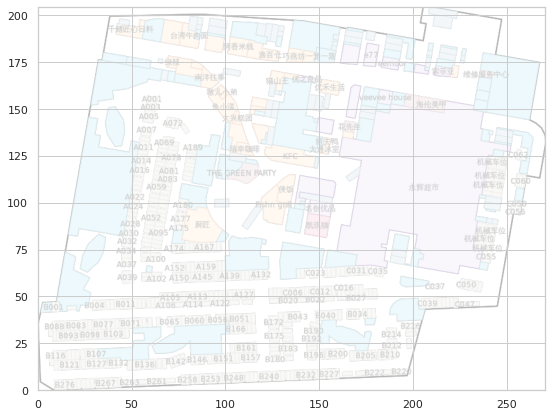

In [7]:
plt.figure(figsize=(20, 10))
plt.subplot(121)
plt.imshow(floor_image, extent=(0, floor_width, 0, floor_height), alpha=0.3)
plot_traces(wifi_model_mse, mini_batch_train_wifi)
plt.ylim((110, 200))
plt.title("mse_wifi train")
plt.legend()

plt.subplot(122)
plt.imshow(floor_image, extent=(0, floor_width, 0, floor_height), alpha=0.3)
plot_traces(wifi_model_mse, mini_batch_test_wifi)
plt.ylim((110, 200))
plt.title("mse_wifi test")
plt.legend()
plt.show()

### Beacon model

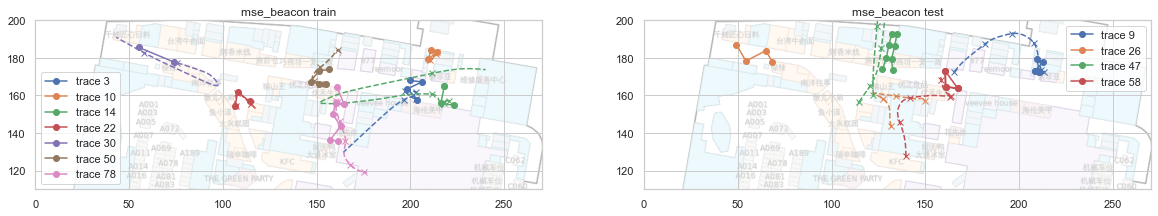

In [26]:
plt.figure(figsize=(20, 10))
plt.subplot(121)
plt.imshow(floor_image, extent=(0, floor_width, 0, floor_height), alpha=0.3)
plot_traces(beacon_model_mse, mini_batch_train_beacon)
plt.ylim((110, 200))
plt.title("mse_beacon train")
plt.legend()

plt.subplot(122)
plt.imshow(floor_image, extent=(0, floor_width, 0, floor_height), alpha=0.3)
plot_traces(beacon_model_mse, mini_batch_test_beacon)
plt.ylim((110, 200))
plt.title("mse_beacon test")
plt.legend()
plt.show()

The hyper parameters are chosen such that the distance of the test traces are as close as possible to the labels $\boldsymbol {\hat x}$. Indeed the test traces are now a bit closer to labels than in notebook 3, for the beacon model at least. However, the performance is still bad. Also, note that since this model was chosen based on the test MSE, any performance evaluation will be biased. 

Still, we may investigate whether the beacon model is able to give more reasonable estimates of the wifi locations.

In [27]:
from src.plotting import get_wifi_strengths

wifi_indices = [0, 1, 2, 3, 4, 5]
wifi_bssids = [floor_data_beacon.bssids_[i] for i in wifi_indices]
wifi_strengths = get_wifi_strengths(floor_data_beacon, wifi_bssids)

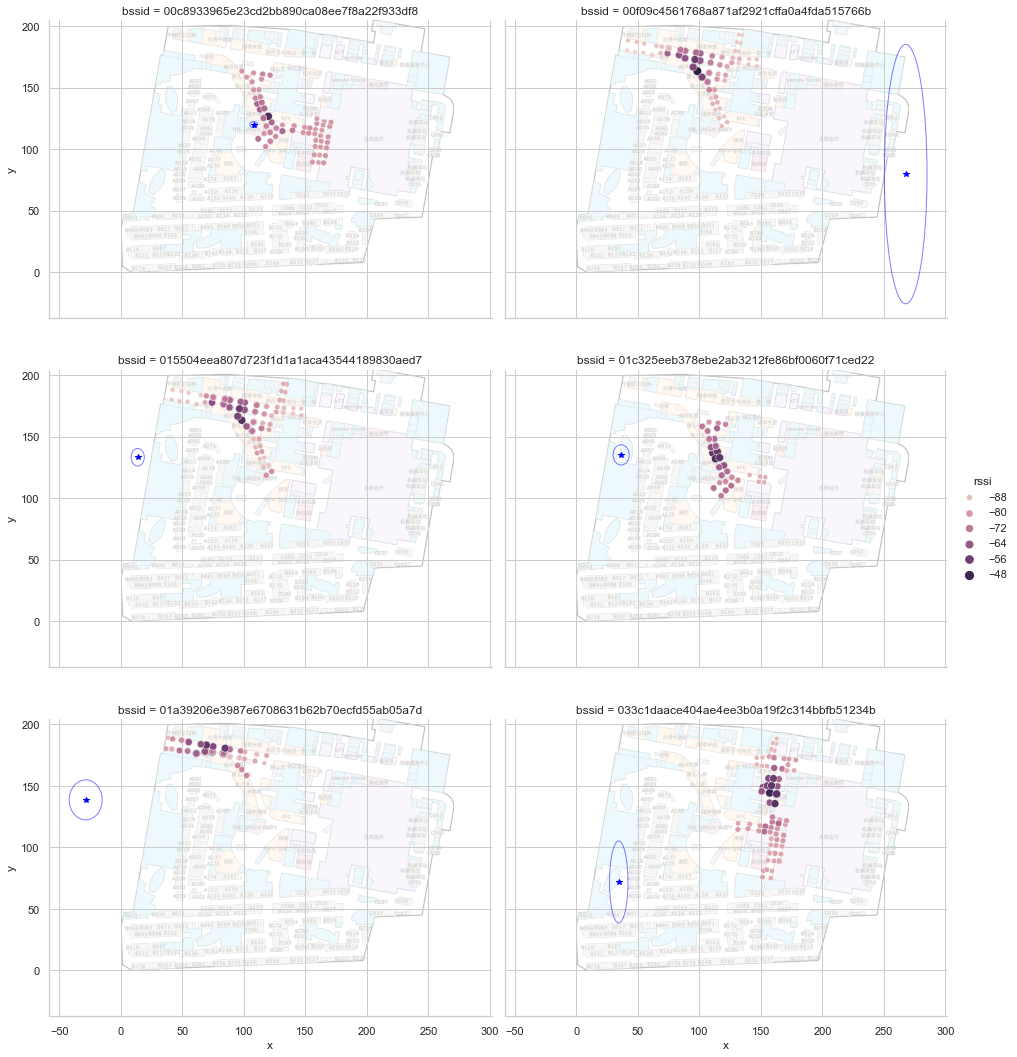

In [28]:
fg = sns.relplot(data=wifi_strengths, x="x", y="y", col="bssid", col_wrap=2, hue="rssi", size='rssi', aspect=floor_width/floor_height)
for bssid, ax in fg.axes_dict.items():
    ax.imshow(floor_data_beacon.image, extent=(0, floor_width, 0, floor_height), alpha=0.3)
    plot_wifi(beacon_model_mse, [wifi_bssids.index(bssid)], ax=ax, color="blue")

This is very similar to the result of the previous models.